# Resources:
- https://keras.io/examples/lstm_text_generation/
- "Temperature" - http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- 

In [109]:
CPUS = 7

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Data Packages
import pickle
import pandas as pd
import numpy as np
import itertools
from collections import OrderedDict
pd.set_option('display.max_colwidth', 100)
# pd.set_option('display.max_colwidth', -1)

# General packages
import time
import math
import random
from pprint import pprint

# System and OS
import os
import pathlib
import glob
import time

# Parsing
import json
import optparse


# NLP Packages

# regex
import re

# Gensim
import gensim
# import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
from gensim.test.utils import datapath
from gensim.models import Word2Vec 

# SpaCy
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# NLTK
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import nltk.corpus  
from nltk.text import Text

# string, textblob
from textblob import TextBlob
import string

# Tensorflow and Keras
# import tensorflow as tf
import keras
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

C:\Users\pnbutler\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\pnbutler\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict


In [3]:
# Time operation

# time the process
tic = time.perf_counter()

# do something

# time the process
toc = time.perf_counter()
print("The process took {} seconds".format(toc - tic))

The process took 3.8000000003535206e-05 seconds


In [4]:
def save_to_pickle(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)
    f.close()

def open_pickle(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [5]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # navigate to directory with pickle file\
# DATA_PATH = "/content/drive/My Drive/NLP_fp"
PKL_DATA_PATH = r"C:\Users\pnbutler\Documents\MSCA\ML\Project\Datasets\pickle files"
MODEL_DATA_PATH = r"C:\Users\pnbutler\Documents\MSCA\ML\Project\Models"
FILE_NAME = r"df_14642.pkl"
os.chdir(PKL_DATA_PATH)
os.getcwd()

'C:\\Users\\pnbutler\\Documents\\MSCA\\ML\\Project\\Datasets\\pickle files'

In [6]:
df = open_pickle(FILE_NAME)

In [7]:
# change to model path to save files
os.chdir(MODEL_DATA_PATH)
os.getcwd()

'C:\\Users\\pnbutler\\Documents\\MSCA\\ML\\Project\\Models'

In [8]:
df.sample()

,Artist,Title,Tagged_lyrics,Verse_Lines,Verses,Chorus,Song_structure
2502,Chief Keef,Black Ops,"[(Hook, I keep that hot shit like a Tea pot OG stuffed in a cookie jar Pull up, boy you better h...","[[10, 20, 30, Bullets flying like birdy, I'm a Chiraq warrior, and I'm balling like I'm Curry, I...","[10, 20, 30, Bullets flying like birdy I'm a Chiraq warrior, and I'm balling like I'm Curry If y...","[I keep that hot shit like a Tea pot OG stuffed in a cookie jar Pull up, boy you better have the...","[Hook, Verse, Hook, Verse, Hook]"


In [9]:
print("{} artists".format(len(df.Artist.unique())))

248 artists


In [10]:
artists_to_drop = [
    "Nicole Scherzinger",
    "Niykee Heaton",
    "Nicole Scherzinger",
    "Niykee Heaton",
    "Bebe Rexha",
    "Ciara",
    "Demi Lovato",
    "David Guetta",
    "Ed Sheeran",
    "Jake Paul",
    "Jennifer Lopez",
    "JoJo",
    "Joe Budden",
    "Keri Hilson",
    "Knoc-turn’al",
    "Lauryn Hill",
    "ONHEL",
    "Queen Latifah",
    "Sean Kingston",
    "Shakira",
    "Selena Gomez",
    "Teairra Marí",
    "Tove Lo",
    "will.i.am",
    "Cassie",
    "Chris Brown"
]

In [11]:
df = df[~df.Artist.isin(artists_to_drop)]

In [12]:
print("{} artists".format(len(df.Artist.unique())))

224 artists


In [13]:
for i in df.Artist.unique():
    print(i)

03 Greedo
2 Chainz
21 Savage & Metro Boomin
21 Savage
21 Savage, Offset & Metro Boomin
2Pac
50 Cent
6ix9ine
A Boogie wit da Hoodie
A Tribe Called Quest
A$AP Ferg
A$AP Mob
A$AP Rocky
Ace Hood
Akon
Avant
B.G. (Baby Gangsta)
B.G. Knocc Out
Bazzi
Big K.R.I.T.
Big L
Big Sean
Birdman & Lil Wayne
Birdman
blackbear
Bone Thugs-N-Harmony
Bun B
Busta Rhymes
Cam’ron
Cardi B
Carnage
Chance the Rapper
Chief Keef
Childish Gambino
Clipse
Curren$y
D Savage
David Banner
Denzel Curry
Desiigner
Dizzee Rascal
DJ Drama
DJ Khaled
DJ Scream
DJ Snake & Sheck Wes
DJ Wich
DMX
Don Toliver
Dr. Dre
Drake & Future
Drake & Michael Jackson
Drake
Drake, Kanye West, Lil Wayne & Eminem
Drakeo the Ruler
Eminem
Enrique Iglesias
Eric B. & Rakim
Euro
Famous Dex
Fat Joe
French Montana
Future
G-Unit
Glasses Malone
Grandmaster Flash & The Furious Five
Gucci Mane & Anuel AA
Gucci Mane & Nicki Minaj
Gucci Mane & Waka Flocka Flame
Gucci Mane
Gucci Mane, Bruno Mars & Kodak Black
Gunna
Hopsin
Ice Cube
J. Cole
Ja Rule
Jadakiss
Jay Ro

In [14]:
print("{} songs".format(len(df)))

14608 songs


In [15]:
print("On averge, {} songs per artist".format(round(df.Artist.value_counts().values.mean(),ndigits=1)))

On averge, 65.2 songs per artist


In [16]:
verse_list = list(df.Verses)
verse_list = list(itertools.chain.from_iterable(df["Verses"]))

In [17]:
print("{} verses".format(len(verse_list)))

33180 verses


In [18]:
verse_list[:1]

["She ain't love me 'til she saw me shine Playin' with a nigga all this time You ain't love me 'til you saw me shine Playin' with a nigga all this time She wear a minute, now I'm on your mind Since I lost Lil Money I been on my grind Always been one hundred, never told her lies I can't let her go, I will never really know why Shay Shay you got my attention Sorry for times I went missing Have you heard 'bout whose lips I'm kissin' I understand why you keepin' your distance But I still love you And I never care who done fucked you Been in this game, I can't judge you, wave it above you That's what these lames do Know I done played you so I can't blame you But why you so playful? don't make me hate you I never fake and act like you wasn't there when I had nothing at the bottom Now I'm at the top, that's why anything that you ever wanted,  know you got it Sucker for love, fuck with a thug She ain't leave when I was broke and I was strung out on them drugs Stored at nothin' but under three 

In [19]:
verse_line_list = list(itertools.chain.from_iterable(df["Verse_Lines"]))
verse_line_list = list(itertools.chain.from_iterable(verse_line_list))

In [20]:
print("{} lines".format(len(verse_line_list)))

555696 lines


In [21]:
verse_line_list[:1]

["She ain't love me 'til she saw me shine"]

In [22]:
delimiter_ = ", "
word_list = delimiter_.join(verse_line_list)

In [23]:
print("{} words".format(len(word_list)))

24861710 words


In [24]:
df_verses = pd.DataFrame(data = verse_line_list)
df_verses.columns = ["Verse_lines"]

In [25]:
df_verses['word_count']= df_verses['Verse_lines'].apply(lambda x:len(str(x).split(" ")))

In [26]:
df_verses['word_count'].describe() ## 9 +/- 6 words are the normal range

count    555696.000000
mean          8.679096
std           3.028821
min           1.000000
25%           7.000000
50%           9.000000
75%          11.000000
max         195.000000
Name: word_count, dtype: float64

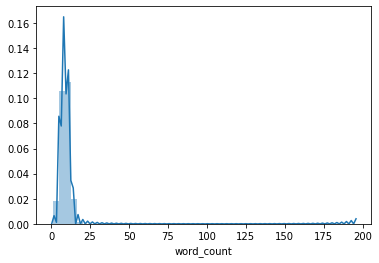

In [27]:
sns.distplot(df_verses.word_count)

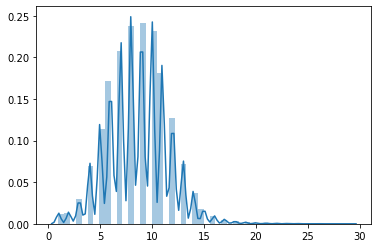

In [28]:
# zoom in < 30
sns.distplot(df_verses.loc[df_verses["word_count"]<30,["word_count"]])

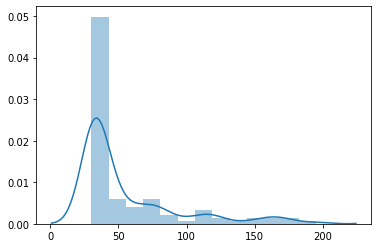

In [29]:
# zoom in >= 30
sns.distplot(df_verses.loc[df_verses["word_count"]>=30,["word_count"]])

In [30]:
# it appears as if these verses are not properly subsetted
df_verses.loc[df_verses["word_count"]>=30,:].sample(10)

,Verse_lines,word_count
175991,"You bout to go get a degree, I'ma be stuck with two choices: Either graduate to weight or sellin...",30
351457,I Guess They Like The Way I Roll On The Phantom Rolls On 24s Or The Candy Slab With The Top Drop...,173
452491,"Make it seem like you ain't rushing tryna take it slow, you 29 nigga what the fuck you waiting f...",30
145889,"But these hoes mad (They what?), hoes mad (Hoes mad), I think I fucked her best friend (Her what...",30
233459,"Because you got things to do and I'm an artist, and I'm about to blow, and I'm about the dough, ...",31
522148,6 in the mornin my alarm goes off don't go stop the pot then the stove goes off knock back on th...,117
547664,Tryna go I am so TTG nigga its pressuring me screaming out murder me hit her with style no one f...,67
481681,Better believe he don't eat it I deliver lik a pizza heat of da moment homies I get flat lik add...,78
547663,Go she say I know you I'm really in front you I really don't want you whatever it come to but I ...,195
175989,"When he seen I was sure 17 years breathing his demeanor said more He told me, ""Nigga, you know h...",32


In [31]:
# 7  11
df_verses[(df_verses['word_count'] >= 3) & (df_verses['word_count'] <= 15)].sample(5)

,Verse_lines,word_count
295663,"Everybody know I'm next, ooh",5
266336,"Ghost in, roll the carpets out",6
344288,Got her thanking mouth 'cause you nasty,7
31911,Initiated as an Outlaw back in '94,7
294569,"I'm with your bitch (with your bitch), I'm on her ass (I'm on her ass)",15


In [32]:
## filter out outliers for word count - 9 +/- 6 words are the normal range for word count (mean +/- 2* std)
df_verses = df_verses[(df_verses['word_count'] >= 3) & (df_verses['word_count'] <= 15)]
df_verses.shape[0]

540724

# Model 5 - character level 1dCNN

In [110]:
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LambdaCallback, EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.optimizers import RMSprop
from keras.utils import get_file
import numpy as np
import random
import sys
import io
import requests
import re

In [137]:
CONTRACTION_MAP = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"'till": "until"
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

SyntaxError: invalid syntax (<ipython-input-137-09aed201fb7c>, line 78)

In [138]:
# expand contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    try:
        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
    except:
        expanded_text = text

    return expanded_text

In [128]:
# This did not feel good to type
bad_words = ["fuck", "motherfucker", "nigga", "niggas", "shit", "bitch", "slut", "cunt", "pussy", "fuckin", "bitches", "fucks", "fucked", "fuckers", "shitty"]

In [129]:
mask = df_verses.loc[:, "Verse_lines"].str.contains(r'\b(?:{})\b'.format('|'.join(bad_words)), case = False)
clean_df = df_verses[~mask]

In [130]:
print("We cleaned up {} dirty verses".format(df_verses.shape[0] - clean_df.shape[0]))

We cleaned up 119638 dirty verses


In [131]:
print("{} total safe lines left".format(clean_df.shape[0]))

421086 total safe lines left


In [143]:
lines_safe = list(set(list(clean_df.Verse_lines)))
print("{} unique safe lines".format(len(lines_safe)))

398803 unique safe lines


In [144]:
# randomly sample 100,000 rap lines to start  
DATA_SIZE = 5000
data = random.sample(lines_safe, DATA_SIZE)

In [146]:
# get all words for modeling
delimiter_ = ", "
data = delimiter_.join(lines_safe)

In [148]:
# clean up words

# convert to lower case
data = data.lower()

# expand contractions
data = [expand_contractions(x, contraction_mapping=CONTRACTION_MAP) for x in data]

# remove non-alphanumeric characters
data = re.sub(r'[^a-zA-Z0-9 ]', '', str(data))

In [149]:
len(data)

16459034

In [150]:
data[:50]

'i look up in the sky see that ghetto bird circling'

In [152]:
chars = sorted(list(set(data))) # same as model 2
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [153]:
# https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_3_text_generation.ipynb

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(data) - maxlen, step):
    sentences.append(data[i: i + maxlen])
    next_chars.append(data[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 5486332


In [154]:
vocab_size = len(chars)
vocab_size

37

In [155]:
# reducing dimensionality by creating maxlen chunks
print(len(data) - len(sentences))

10972702


In [156]:
# sentences[:20]

In [157]:
# Vectorization
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [158]:
# using indices to vectorize
# (number of sequences, input vector, dummy variables for the output)
x.shape

(5486332, 40, 37)

In [159]:
# (number of sequences, dummy variables for the output)
y.shape

(5486332, 37)

In [160]:
N_TIMESTEPS, N_FEATURES, N_OUTPUTS = x.shape[1], x.shape[2], x.shape[1]

In [161]:
# build the model: a character-level LSTM
model = Sequential()

In [162]:
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(maxlen, vocab_size)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [163]:
# LSTM
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 38, 64)            7168      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 36, 64)            12352     
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 64)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               115300    
_________________________________________________________________
dense_10 (Dense)             (None, 37)               

The sample function is what will actually produce the results. The LSTM will produce new text character by character. We will need to sample the correct letter from the LSTM predictions each time. The sample function accepts the following two parameters:
- preds - The output neurons.
- temperature - 1.0 is the most conservative (will only take letter with highest probability), 0.0 is the most confident (willing to make spelling and other errors).

The sample function below is essentially performing a softmax on the neural network predictions. This causes each output neuron to become a probability of its particular letter.

In [164]:
# this is what actually generates the results, passes the output 
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [165]:
# print callback
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print("*"*60)
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(data) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = data[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [166]:
# model checkpoint callback
from keras.callbacks import ModelCheckpoint

filepath = "char_level_1dCNN_weights.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

In [167]:
# reduce learning rate on plateau callback

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [168]:
# early stopping
early_stopping  = EarlyStopping(monitor='loss', mode = "min",  verbose = 1, patience=11, )

In [169]:
# set model params
BATCH_SIZE = 128
EPOCHS = 30
CALLBACKS = [print_callback, checkpoint, reduce_lr, early_stopping]

In [170]:
# Ignore useless W0819 warnings generated by TensorFlow 2.0.  Hopefully can remove this ignore in the future.
# See https://github.com/tensorflow/tensorflow/issues/31308

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [171]:
# WHY NO GPU?
# https://stackoverflow.com/questions/50347159/keras-does-not-use-gpu-how-to-troubleshoot/50359157
# https://medium.com/@kegui/how-do-i-know-i-am-running-keras-model-on-gpu-a9cdcc24f986
# https://towardsdatascience.com/tensorflow-gpu-installation-made-easy-use-conda-instead-of-pip-52e5249374bc

In [172]:
history = model.fit(x, y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=CALLBACKS)

Epoch 1/30
5486332/5486332 [==============================] - 566s 103us/step - loss: 2.0022 - accuracy: 0.4101
************************************************************
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "in to the moon im the man man two tabs o"
in to the moon im the man man two tabs on the stor the back the band the mind the tack and i want i got the dont take you say i bong the better i got the could on the dand i got the dand im a shot the dont to the got the dont ho pack in the back the talk i say the dand i dont take the can the stalk the band i she talk you say i she say im the stuck the gand the gang i can the same the came i got the came i got the bad i got my shit it t
----- diversity: 0.5
----- Generating with seed: "in to the moon im the man man two tabs o"
in to the moon im the man man two tabs on exde the made on the fand the show it bot aint we got the gon the in you beon on the mis bocks and my gind you hock war you

C:\Users\pnbutler\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


se i got the could i peep the gon the got i was the some i kill the bout the got the bout the should you and the store the tot a store i got the bor the bon the store the got the crow i stol i got the could i dont to got the better the bein the for the bomn i got the money the toat i so ming the cause i want
----- diversity: 0.5
----- Generating with seed: " you a mothafuckin white boy lions tiger"
 you a mothafuckin white boy lions tiger come got the just like on mich i crop my well and on coke a me mind for the word the rick and cros the call me the mind take it my shand bout bout the damn who no peep the gop the talk that you dont look of on come you move wanna know you i got the stout em money chang and lnon my best its a coup it this in the got that that  to the sreas man my pockess that channit i she got they come i know i b
----- diversity: 1.0
----- Generating with seed: " you a mothafuckin white boy lions tiger"
 you a mothafuckin white boy lions tiger m owd i coma hlecpbecy y

In [174]:
print("Hyperparameters")
print("Data size: ", DATA_SIZE)
print("Epochs: ", EPOCHS)
print("Batch size: ", BATCH_SIZE)
# print("Learning rate: ", LR)
print("Layers: ", len(model.layers))
print("Loss: ", history.history["loss"][-1])
print("Accuracy: ", history.history["accuracy"][-1])

Hyperparameters
Data size:  5000
Epochs:  30
Batch size:  128
Layers:  7
Loss:  1.8183153916128116
Accuracy:  0.4550997


In [175]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(data) - maxlen - 1)
    generated = ''
    sentence = data[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [176]:
GENERATED_LENGTH = 200
DIVERSITY_ = 1

In [186]:
print(generate_text(GENERATED_LENGTH, DIVERSITY_), "\n")
print(generate_text(GENERATED_LENGTH, DIVERSITY_), "\n")
print(generate_text(GENERATED_LENGTH, DIVERSITY_), "\n")
print(generate_text(GENERATED_LENGTH, DIVERSITY_), "\n")
print(generate_text(GENERATED_LENGTH, DIVERSITY_), "\n")

C:\Users\pnbutler\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


we all fighting i showed grandma my first crisk bregcii and sip neidtl pisvsgtr i just night you aekcafwaedny the for of somilasatler stain but suss me frad unocnes plere the johs and a dundaekt home it dont could prav them facetde bibeen d 

ny im really tryna make it more than what strae pipe for yiree huhs in way be of an i fide yeap you wu chapooin nittin recaqle swoar ever they can heaure how on that swetaae halfrvadseslalueu the konsatlaise with my getefash to i for i hop  

onal no insurance no informants close that kidos might right obore dolastery about the ball minet it feel and of the asniz pory enoge on the we dave yeah the tone my hell your obeln last cott and a iag everybody pillin with big ea  fipper g 

unnin round my head black card credit toe roos dontids in on in my sopped crank do homban got  waitin you ronme is inti the i meing o ilis on whire sriities from coys my dodimd to vlew didols through ever whole i cread hlaw in the stay in m 

ff the shits we no friend ba

In [181]:
# save model
import json
import optparse

# serialize model to JSON
final_json = model.to_json()
with open("CNN_final_model.json", "w") as json_file:
    json_file.write(final_json)
# serialize weights to HDF5
model.save_weights("CNN_final_model.h5")
print("Saved model to disk")

Saved model to disk


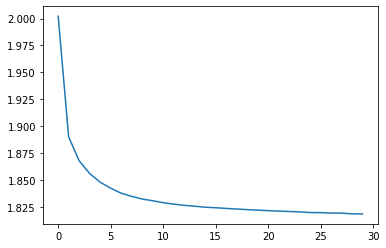

In [179]:
# plot metrics
plt.plot(history.history['loss'])
plt.show()

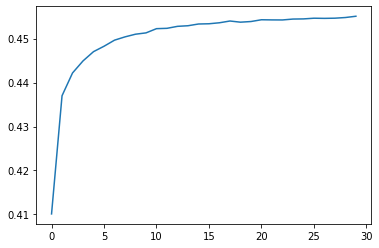

In [180]:
# plot metrics
plt.plot(history.history['accuracy'])
plt.show()